## Flux comparions
The goal of this notebook is to compare the predictions of the R. opacus PD630 GSM with the fluxes from 13C-Metabolic Flux Analysis (13C-MFA)

### Setup imports

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import cobra
import pandas as pd
import numpy as np
from edd_utils import login, export_study, export_metadata

### Import most recent GSM 

In [2]:
edd_study_slug = 'input-test-study'
edd_server = 'public-edd.agilebiofoundry.org'
user= 'garrettroell'
session = login(edd_server=edd_server, user=user)
# df = utils.load_study(edd_study_slug=edd_study_slug,edd_server=edd_server,
#   default_to_system_user=False)

Password for garrettroell:  ················


In [3]:
df = export_study(session, edd_study_slug, edd_server=edd_server)

In [4]:
df

,Study ID,Study Name,Line ID,Line Name,Line Description,Protocol,Assay ID,Assay Name,Formal Type,Measurement Type,Compartment,Units,Value,Hours


In [5]:
model_path = "../GSMs/Ropacus_annotated_curated.xml"
model = cobra.io.read_sbml_model(model_path)
model

Name,ropacus_annotated_curated
Memory address,0x07ff9b9d9b0d0
Number of metabolites,1581
Number of reactions,2380
Number of groups,0
Objective expression,1.0*Growth - 1.0*Growth_reverse_699ae
Compartments,"cytosol, periplasm, extracellular space"


### Run glucose flux FBA

In [6]:
model.objective = "Growth"
with model:
    medium = model.medium
    medium["EX_glc__D_e"] = 10.0
    model.medium = medium
    solution = model.optimize()
    print(solution)

<Solution 0.792 at 0x7ff9b9e07990>


### Get 13C MFA measured fluxes

In [7]:
glucose_flux_path = "../13C_flux_data/13C_glucose_flux_data.csv"
measured_glucose_df = pd.read_csv(glucose_flux_path)
measured_glucose_df

,Pathway,Reaction ID,Reversed?,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,Unnamed: 7,Unnamed: 8
0,Glucose Uptake,NaN,NaN,Gluc.ext + ATP -> G6P,1.000000e+02,100.0000,1.000000e+02,NaN,NaN
1,Glycolysis,PGI,False,G6P <-> F6P,-1.610000e+00,-2.0900,1.420000e+00,NaN,NaN
2,NaN,NaN,NaN,F6P + ATP -> FBP,0.000000e+00,0.0000,1.910000e+00,NaN,NaN
3,NaN,FBA,False,FBP <-> DHAP + GAP,0.000000e+00,0.0000,1.910000e+00,NaN,NaN
4,NaN,TPI,False,DHAP <-> GAP,0.000000e+00,0.0000,1.910000e+00,NaN,NaN
5,NaN,NaN,NaN,GAP <-> 3PG + ATP + NADH,8.656000e+01,82.6100,8.884000e+01,NaN,NaN
6,NaN,NaN,NaN,3PG <-> PEP,7.852000e+01,71.6500,8.126000e+01,NaN,NaN
7,NaN,NaN,NaN,PEP <-> Pyr + ATP,1.902000e+01,-10.8900,7.515000e+01,NaN,NaN
8,Pentose Phosphate Pathway,NaN,NaN,G6P <-> 6PG + NADPH,1.000000e+02,96.9600,1.000000e+02,NaN,NaN
9,NaN,NaN,NaN,6PG <-> Ru5P + CO2 + NADPH,6.620000e+00,2.0700,1.092000e+01,NaN,NaN


Eliminate all rows that do not have a defined reactionID

In [8]:
measured_glucose_df = measured_glucose_df[~pd.isnull(measured_glucose_df['Reaction ID'])]
measured_glucose_df

,Pathway,Reaction ID,Reversed?,Reaction,Flux,90% Confidence Lower Bound,90% Confidence Upper Bound,Unnamed: 7,Unnamed: 8
1,Glycolysis,PGI,False,G6P <-> F6P,-1.61,-2.09,1.42,NaN,NaN
3,NaN,FBA,False,FBP <-> DHAP + GAP,0.00,0.00,1.91,NaN,NaN
4,NaN,TPI,False,DHAP <-> GAP,0.00,0.00,1.91,NaN,NaN
17,ED Pathway,EDA,False,6PG <-> KDPG,93.38,89.08,94.98,NaN,NaN
18,NaN,EDD,False,KDPG <-> Pyr + GAP,93.38,89.08,94.98,NaN,NaN
19,TCA Cycle,PDH,False,Pyr <-> AcCoA + CO2 + NADH,135.41,116.26,196.60,NaN,NaN
20,NaN,CS,False,OAC + AcCoA <-> Cit,69.04,58.52,82.65,NaN,NaN
21,NaN,ACONT,False,Cit <-> ICit,69.04,58.52,82.65,NaN,NaN
23,NaN,AKGDH,False,AKG <-> SucCoA + CO2 + NADH,61.60,2.27,75.99,NaN,NaN
24,NaN,SUCOAS,True,SucCoA <-> Suc + ATP,59.88,0.87,74.45,NaN,NaN


In [9]:
measured_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
#     print(measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Reversed?'].values[0])
    measured_flux = measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Flux'].values[0] / 10
#     if measured_glucose_df[measured_glucose_df['Reaction ID'] == reaction_id]['Reversed?'].values[0]:
#         measured_flux = -1 * measured_flux
    measured_flux_dict[reaction_id] = measured_flux
measured_flux_dict

{'PGI': -0.161,
 'FBA': 0.0,
 'TPI': 0.0,
 'EDA': 9.338,
 'EDD': 9.338,
 'PDH': 13.541,
 'CS': 6.904000000000001,
 'ACONT': 6.904000000000001,
 'AKGDH': 6.16,
 'SUCOAS': 5.988,
 'FUM': 6.327,
 'ICL': 0.0,
 'MALS': 0.0}

### Get FBA simulated fluxes

In [10]:
simulated_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
    simulated_flux_dict[reaction_id] = solution.fluxes[reaction_id]

simulated_flux_dict

{'PGI': 9.84244787353533,
 'FBA': 0.0,
 'TPI': 8.664556409477846,
 'EDA': 0.0,
 'EDD': 0.0,
 'PDH': 10.401773677697557,
 'CS': 0.8099224524147408,
 'ACONT': 0.0,
 'AKGDH': 0.0,
 'SUCOAS': 0.27149766705871087,
 'FUM': 0.5445055288906073,
 'ICL': 0.0,
 'MALS': 0.0006855438868609784}

### Plot FBA vs measured fluxes

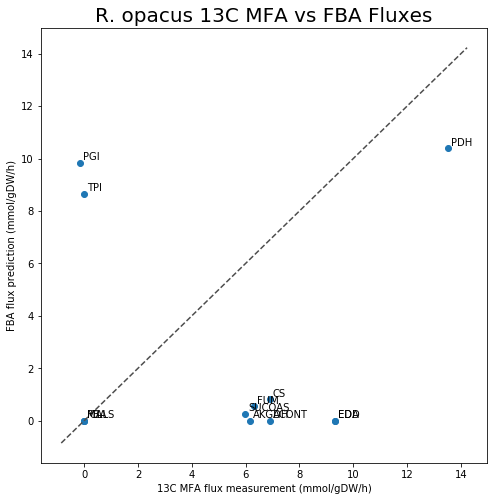

In [11]:
measured_flux_list = list(measured_flux_dict.values())
simulated_flux_list = list(simulated_flux_dict.values())
labels = list(measured_flux_dict.keys())

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(measured_flux_list, simulated_flux_list)
# ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")
for i in range(len(labels)):
    xy = (measured_flux_list[i]+.1,simulated_flux_list[i]+.1)
    ax.annotate(labels[i],xy)
plt.title(r'R. opacus 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux measurement (mmol/gDW/h)')
plt.ylabel(r'FBA flux prediction (mmol/gDW/h)')
plt.show()

### Simulate with pfba

In [12]:
pfba_solution = cobra.flux_analysis.pfba(model)
len(pfba_solution.fluxes)

2380

In [13]:
pfba_flux_dict = {}
measured_reaction_ids = list(measured_glucose_df['Reaction ID'])
for reaction_id in measured_reaction_ids:
    pfba_flux_dict[reaction_id] = pfba_solution.fluxes[reaction_id]

pfba_flux_dict

{'PGI': 9.84244787353533,
 'FBA': 0.0,
 'TPI': 8.664556409477841,
 'EDA': 0.0,
 'EDD': 0.0,
 'PDH': 10.081342739111987,
 'CS': 0.8099224524147406,
 'ACONT': 0.8099224524147406,
 'AKGDH': 0.0,
 'SUCOAS': 0.3897839608735948,
 'FUM': 0.5445055288902496,
 'ICL': 0.0,
 'MALS': 0.0006855438868609218}

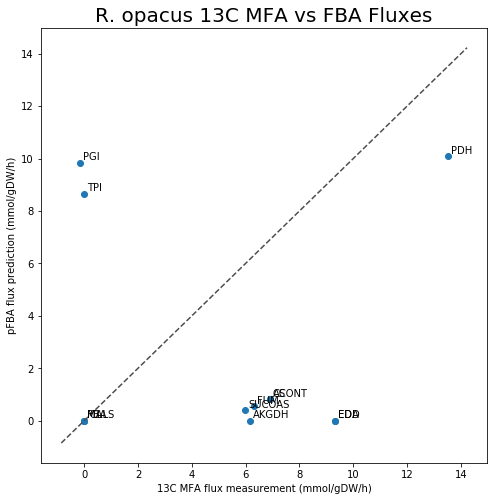

In [14]:
measured_flux_list = list(measured_flux_dict.values())
simulated_flux_list = list(pfba_flux_dict.values())
labels = list(measured_flux_dict.keys())

fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(measured_flux_list, simulated_flux_list)
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, ls="--", c=".3")
for i in range(len(labels)):
    xy = (measured_flux_list[i]+.1,simulated_flux_list[i]+.1)
    ax.annotate(labels[i],xy)
plt.title(r'R. opacus 13C MFA vs FBA Fluxes', fontSize=20)
plt.xlabel(r'13C MFA flux measurement (mmol/gDW/h)')
plt.ylabel(r'pFBA flux prediction (mmol/gDW/h)')
plt.show()

### Simulate with geometric FBA

In [15]:
# geometric_fba_sol = cobra.flux_analysis.geometric_fba(model)
# len(geometric_fba_sol.fluxes)

In [16]:
for r in model.metabolites.get_by_id('mal__L_c').reactions:
    print(r.name, r)

Malate transport via proton symport (2 H) MALt2_2: 2.0 h_e + mal__L_e --> 2.0 h_c + mal__L_c
Malate dehydrogenase (ubiquinone 8 as acceptor) MDH2: mal__L_c + q8_c --> oaa_c + q8h2_c
(S)-Malate:(acceptor) oxidoreductase DMALRED: fad_c + mal__L_c --> fadh2_c + oaa_c
Malic enzyme (NADP) ME2: mal__L_c + nadp_c --> co2_c + nadph_c + pyr_c
Alpha ketoglutaratemalate transporter AKGMAL: akg_c + mal__L_e <=> akg_e + mal__L_c
Fumarase FUM: fum_c + h2o_c <=> mal__L_c
Malate transport via proton symport (2 H) (periplasm) MALt2_2pp: 2.0 h_p + mal__L_p --> 2.0 h_c + mal__L_c
Malate transport via diffusion (periplasm to cytosol) MALtpp: h_p + mal__L_p <=> h_c + mal__L_c
Malate dehydrogenase (menaquinone 8 as acceptor) MDH3: mal__L_c + mqn8_c --> mql8_c + oaa_c
Malate synthase MALS: accoa_c + glx_c + h2o_c --> coa_c + h_c + mal__L_c
Malic enzyme (NAD) ME1: mal__L_c + nad_c --> co2_c + nadh_c + pyr_c
Malate dehydrogenase MDH: mal__L_c + nad_c <=> h_c + nadh_c + oaa_c
L malate reversible transport via p